In [70]:
import csv
import datetime
import operator
import os
import re
from random import randint
import networkx as nx
import csv
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from operator import itemgetter
from shapely.wkt import loads
import copy
from os import path
import netwulf as nw
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mtick
from os import listdir
import time

In [71]:
NOT_INFECTED=0
INFECTED=1
NUM_NODOS=1
PERCENTAGE = np.float64(0.60)
pathFile = "/Users/silviadelatorre/Desktop/TFG/PFG/Results/PROPAGACIÓN"

enlaces_global = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_GrafoGlobal.csv"
enlaces_duero = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIO DUERO.csv"
enlaces_tajo = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIO TAJO.csv"
enlaces_guadiana = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIO GUADIANA.csv"
enlaces_jucar = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIO JUCAR.csv"
enlaces_ebro = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIO EBRO.csv"
enlaces_segura = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIO SEGURA.csv"
enlaces_garona = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIO GARONA.csv"
enlaces_barbate = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIO BARBATE.csv"
enlaces_ter =  "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIU TER.csv"
enlaces_palancia = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIU PALANCIA.csv"
enlaces_guadalquivir = "/Users/silviadelatorre/Desktop/TFG/EDGE LIST/3 COORDS/Edgelist_20240311_125307_Grafo_RIO GUADALQUIVIR.csv"
rios = [(enlaces_guadalquivir,"RIO GUADALQUIVIR"),(enlaces_palancia,"RIO PALANCIA"),(enlaces_ter,"RIO TER"),(enlaces_barbate,"RIO BARBATE"),(enlaces_garona,"RIO GARONA"),(enlaces_segura,"RIO SEGURA"),(enlaces_guadiana,"RIO GUADIANA"),(enlaces_ebro,"RIO EBRO"),(enlaces_jucar,"RIO JUCAR"),(enlaces_tajo,"RIO TAJO")]

fosfato = "Results/VALORES CONTAMINACION/Fosfato_merged.csv"
amonio = "Results/VALORES CONTAMINACION/Amonio_merged.csv"
fosforo = "Results/VALORES CONTAMINACION/Fosforo_merged.csv"
fitobentos = "Results/VALORES CONTAMINACION/Fitobentos_merged.csv"
nitrato = "Results/VALORES CONTAMINACION/Nitrato_merged.csv"
grado_trofico = "Results/VALORES CONTAMINACION/Grado Trofico_merged.csv"


In [72]:

def CrearGrafo(edge_list):
    # Crear un grafo no dirigido
    global G
    G = nx.DiGraph()

    # Analizar el edge list y agregar los nodos y las aristas al grafo
    with open(edge_list, 'r') as f:
        for line in f:
            nodos_y_atributos = line.strip().split(';')
            nodo1_coords = tuple(map(float, nodos_y_atributos[0][1:-1].split(', ')))
            nodo2_coords = tuple(map(float, nodos_y_atributos[1][1:-1].split(', ')))

            # Agregar la arista al grafo
            G.add_edge(nodo2_coords, nodo1_coords)

    print("Número de nodos:", G.number_of_nodes())
    print("Número de aristas:", G.number_of_edges())
    degrees = G.degree()
    nodes = G.nodes()
    n_color = np.asarray([degrees[n] for n in nodes])
    #GraficarRed(G,n_color)
    return G

In [73]:

def StatusNodes(V):
    'Inicializar dataframe de nodos y estados de infeccion'
    global df, df
    
    Nodes=V.nodes()
    df = pd.DataFrame(Nodes)
    #print(df)
    data = {'Node': Nodes, 'Status': [NOT_INFECTED] * len(Nodes)}
    df = pd.DataFrame(data)

    #print(f'Status data frame: {df}')

In [74]:
def Infected_Nodes(V):
    global df

    #StatusNodes(V)
    TotalNodes = len(V.nodes())
    TotalNodesInfect = df['Status'].sum()

    Rate = TotalNodesInfect/TotalNodes*100
    print(f"Ratio infectados: {Rate:.4f}%")

    return Rate


In [75]:
def CodigodelRio(rio):
    if(rio=='RIO GUADALQUIVIR'):
        codigo = '10094'
    elif(rio=='RIO GARONA'):
        codigo = '10034'
    elif(rio=='RIO MIÑO'):
        codigo = '10038'
    elif(rio=='RIO DUERO'):
        codigo = '1004'
    elif(rio=='RIO TAJO'):
        codigo = '1006'
    elif(rio=='RIO GUADIANA'):
        codigo = '1008'
    elif(rio=='RIO BARBATE'):
        codigo = '10098'
    elif(rio=='RI0 TER'):
        codigo = '20054'
    elif(rio=='RIO LLOBREGAT'):
        codigo = '20052'
    elif(rio=='RIO PALANCIA'):
        codigo = '20036'
    elif(rio=='RIO SEGURA'):
        codigo = '20016'
    elif(rio=='RIO EBRO'):
        codigo='2004'
    elif(rio=='RIO JUCAR'):
        codigo='2002'
    
    return codigo

In [76]:
def ObtenerPrimerNodo(G,agente,rio):
    max = 0
    coord_max_fosfato = None
    print(f'Obtener Nodo más contaminado del {rio}')
    codigo = CodigodelRio(rio)
    print(f"El codigo del {rio} es {codigo}")
    with open(agente, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            # Obtiene el ID del río, la coordenada y el valor de fosfato
            id_rio = row[0]
            coord = row[1]
            valor_contaminante = float(row[2])
            # Comprueba si el valor actual del agente es mayor que el máximo
            if str(id_rio).startswith(str(codigo)) and valor_contaminante > max:
                max = valor_contaminante
                coord_max = coord
                
    print("Mayor valor de contaminación es",max)
    return coord_max

In [77]:
def ObtenerID_Rio(agente,coordenada):
    # Convertir la coordenada a una cadena en el mismo formato que en el DataFrame
    coordenada_str = str(coordenada)
    # Buscar la fila que coincide con la coordenada en el DataFrame de ríos
    df_agente = pd.read_csv(agente)
    row = df_agente[df_agente['coord_TRAMO'] == coordenada_str]
    if not row.empty:
        # Devolver el ID del río si se encuentra una coincidencia
        return row.iloc[0]['ID_RIO']
    else:
        # Si no se encuentra la coordenada, devolver None
        return None
            
                

In [78]:
def DibujarGrafica(Dir,rio,agente,pC, pR):
    
    #mi_path = os.getcwd() + "\\" + "..\\datos\\" + str(Dir)
    print(Dir)
    print(rio)
    mi_path=os.path.join(Dir, f'{rio}_{pC}_{pR}.png')
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title(f'Spread of {agente} in {rio} with pC={pC} and pR={pR}')
    ax.set_xlabel('Infection Time (s)')
    ax.set_ylabel('Infection rate (%)')
    fmt = '%.5f'
    xticks = mtick.FormatStrFormatter(fmt)
    ax.yaxis.set_major_formatter(xticks)
    tabla = os.path.join(Dir, f'{rio}.csv')
    datosHeader = ["Iteracion","Tiempo Infección","Nodos infectados","Ratio infectados","Nodos Totales","pC","pR"]
    datos = pd.read_table(tabla, engine='python', delimiter=' ', header=0, encoding = "ISO-8859-1", names=datosHeader)
    ax.plot(datos['Tiempo Infección'], datos['Ratio infectados'], marker='o')
    ax.legend()
    
    fig.savefig(mi_path)

In [79]:
def InfectarVecinos(V,iter,path,nombre_rio,codigo,agente):
    global Rate, TotalNodes, df, sucesores,Time

    #nodos_infectados = ListaNodosInfectados()
    # Propagar infección a los vecinos de los nodos infectados
    for index, row in df[df['Status'] == INFECTED].iterrows():
        nodo = row['Node']
        sucesores = list(V.successors(nodo))  # Obtener los sucesores del nodo infectado
        id_rio = ObtenerID_Rio(fosfato,nodo)
        print(f'Infectando sucesores de {id_rio}-{nodo}')
        for sucesor in sucesores:
            antecesores = list(V.predecessors(sucesor))
            id_sucesor = ObtenerID_Rio(fosfato,sucesor)
            print(f'Sucesor: {id_sucesor}-{sucesor}')
            # Verificar si el sucesor aún no está infectado y propagar la infección con una cierta probabilidad
            NumNodosInfect= df.Status[(df['Node'].isin(antecesores)) & (df['Status']==INFECTED)].sum()
            #num_susceptibles = len(sucesores)
            if df.loc[df['Node'] == sucesor, 'Status'].values[0] == NOT_INFECTED:
                print("sucesor no está infectado")
                df.loc[df['Node'] == sucesor, 'Status'] = ComprobarInfeccion(NumNodosInfect,pC)
            estado_infeccion_mar = esta_infectado(codigo,agente)
            if estado_infeccion_mar==True:
                print("DESEMBOCADURA INFECTADA")
                GuardarResultados(Rate,TotalNodes,iter,path,nombre_rio)
                return Rate
                

    Rate = Infected_Nodes(V)

    GuardarResultados(Rate,TotalNodes,iter,path,nombre_rio)
    
    return Rate

In [80]:
def ComprobarInfeccion (N, p):
    
    if (np.random.binomial(N,p) > 0):
        print("INFECTION")
        return INFECTED
    else:
        print("NO INFECTION")
        return NOT_INFECTED

def ComprobarRecuperacion (p):
    
    if (np.random.binomial(1,p) > 0):
        return NOT_INFECTED
    else:
        return INFECTED

In [81]:
def VerificarInfeccionVecinos(V,i):

    global TotalNodes, pC

    Neighbours = list(V.successors(i))
    print("NEIGHBOURS",Neighbours)
    NumNodosInfect = df.Status[(df['Node'].isin(Neighbours)) & (df['Status'] == INFECTED)].sum()
    #df.Status[df.Node == i] = ComprobarInfeccion(NumNodosInfect, pC)
    df.loc[df.Node == i, 'Status'] = ComprobarInfeccion(NumNodosInfect, pC)


def AplicarRecuperacion(i):

    global df, pR
	
    df.Status[(df['Node']==i)]=ComprobarRecuperacion(pR)

In [82]:
def ListaNodosInfectados():
    global df

    InfectedNodes = df[df['Status'] == INFECTED]
    print("Nodos infectados:", InfectedNodes)
    return InfectedNodes

def CoordMar(codigo,agente):
    try:
        df = pd.read_csv(agente)
        print("DataFrame cargado correctamente.")
    except FileNotFoundError:
        print(f"Error: El archivo {agente} no fue encontrado.")
        return

    print(f"Verificando ID_RIO: {codigo}")
    
    # Intenta convertir id_rio a int, si es necesario, dependiendo del tipo de datos en el CSV
    try:
        codigo = int(codigo)
    except ValueError:
        pass  # id_rio es una cadena, lo deja sin cambios

    # Filtrar para obtener solo las filas con el ID_RIO especificado
    filas_id_rio = df[df['ID_RIO'] == codigo]
    #print(filas_id_rio)
    # Extraer y imprimir las coordenadas para el ID_RIO especificado
    coordenadas = filas_id_rio['coord_TRAMO'].tolist()
    print(coordenadas)
    return coordenadas

def esta_infectado(codigo,agente):
    global G
    
    punto_mar = CoordMar(codigo,agente)
    print(f"Coordenadas para el ID_RIO {punto_mar}:")
    for nodo in ListaNodosInfectados():
        if nodo == punto_mar:
            print("El mar está infectado")
            return True
        else:
            print("El mar no está infectado")
            return False

In [83]:
def GuardarResultados(Rate,totalNodes,iter,path,rio):
    global pathFile, pC, pR,Time

    id_infectados = []
    for index, row in df[df['Status'] == INFECTED].iterrows():
        nodo_infectado = row['Node']
        id_rio = ObtenerID_Rio(fosfato, nodo_infectado)
        id_infectados.append(id_rio)
        
    datos = pd.DataFrame([[iter, Time, id_infectados, Rate, totalNodes, pC, pR]], columns=['Iteracion', 'Tiempo Infección', 'Nodos infectados', 'Ratio infectados', 'Nodos Totales', 'pC', 'pR'])

    datos['Ratio infectados'] = datos['Ratio infectados'].apply(lambda x: f'{x:.4f}')

    csv_path = os.path.join(path, f'{rio}.csv')
    if not os.path.exists(csv_path):
        # Si el archivo no existe, escribe la cabecera
        datos.to_csv(csv_path, header=True, index=None, mode='w', sep=' ', decimal='.')
    else:
        # Si el archivo ya existe, añade los nuevos datos sin la cabecera
        datos.to_csv(csv_path, header=False, index=None, mode='a', sep=' ', decimal='.')

    Time += 1

In [84]:
def InfectarVecinos(V,iter,path,nombre_rio,codigo,agente):
    global Rate, TotalNodes, df, sucesores,Time

    #nodos_infectados = ListaNodosInfectados()
    # Propagar infección a los vecinos de los nodos infectados
    for index, row in df[df['Status'] == INFECTED].iterrows():
        nodo = row['Node']
        sucesores = list(V.successors(nodo))  # Obtener los sucesores del nodo infectado
        id_rio = ObtenerID_Rio(fosfato,nodo)
        print(f'Infectando sucesores de {id_rio}-{nodo}')
        for sucesor in sucesores:
            antecesores = list(V.predecessors(sucesor))
            id_sucesor = ObtenerID_Rio(fosfato,sucesor)
            print(f'Sucesor: {id_sucesor}-{sucesor}')
            # Verificar si el sucesor aún no está infectado y propagar la infección con una cierta probabilidad
            NumNodosInfect= df.Status[(df['Node'].isin(antecesores)) & (df['Status']==INFECTED)].sum()
            #num_susceptibles = len(sucesores)
            if df.loc[df['Node'] == sucesor, 'Status'].values[0] == NOT_INFECTED:
                print("sucesor no está infectado")
                df.loc[df['Node'] == sucesor, 'Status'] = ComprobarInfeccion(NumNodosInfect,pC)
            estado_infeccion_mar = esta_infectado(codigo,agente)
            if estado_infeccion_mar==True:
                print("DESEMBOCADURA INFECTADA")
                GuardarResultados(Rate,TotalNodes,iter,path,nombre_rio)
                return Rate
                

    Rate = Infected_Nodes(V)

    GuardarResultados(Rate,TotalNodes,iter,path,nombre_rio)
    
    return Rate

In [85]:
def ListaNodosInfectados():
    global df

    InfectedNodes = df[df['Status'] == INFECTED]
    #print("Nodos infectados:", InfectedNodes)
    return InfectedNodes['Node'].tolist()

def ObtenerCoordMar(agente,codigo):
    try:
        df = pd.read_csv(agente)
        print("DataFrame cargado correctamente.")
    except FileNotFoundError:
        print(f"Error: El archivo {agente} no fue encontrado.")
        return

    print(f"Verificando ID_RIO: {codigo}")
    # Intenta convertir id_rio a int, si es necesario, dependiendo del tipo de datos en el CSV
    try:
        codigo = int(codigo)
    except ValueError:
        pass  # id_rio es una cadena, lo deja sin cambios
    # Filtrar para obtener solo las filas con el ID_RIO especificado
    filas_id_rio = df[df['ID_RIO'] == codigo]
    #print(filas_id_rio)
    if filas_id_rio.empty:
        print(f"No se encontraron filas para el ID_RIO {codigo}.")
        return
    # Extraer y imprimir las coordenadas para el ID_RIO especificado
    coordenadas = filas_id_rio['coord_TRAMO'].tolist()
    print(coordenadas)
    return coordenadas

def esta_infectado(codigo,agente):
    global G
    punto_mar = ObtenerCoordMar(agente,codigo)
    #punto_mar = [(344001.6541, 4241143.825), (344002.6641, 4241143.825)]
    print(f"Coordenadas desembocadura :{punto_mar}")
    for nodo in ListaNodosInfectados():
        print(f'{nodo} vs {punto_mar}')
        if str(nodo) in punto_mar:
            print("La desembocadura está infectada")
            return True
        else:
            print("La desembocadura no está infectada")
            return False

    

In [86]:
def EjecutarIteracionInfeccion(V,Tipo,nombre,path):
    '''Función para ejecutar una iteración de la simulación'''

    global pathFile, Time, df, Rate, TotalNodes,NDir
    
    Iter=0
    TotalNodes=0
    Rate=0
    Time=0
    
    print("Iteracion " + str(Iter))
    
    print("Propagando infeccion")

    Nodes=V.nodes()
    TotalNodes = len(Nodes)
    #print("Total nodes " + str(TotalNodes))
    FirstNode = ObtenerPrimerNodo (V, Tipo,nombre)
    print("Primer nodo infectado")
    print(FirstNode)
    FirstNode = tuple(map(float, FirstNode.strip('()').split(', ')))
    Time = time.time()
    df.loc[df['Node'] == FirstNode, 'Status'] = INFECTED

    df.to_csv('nodos_dataframe.csv', index=False)
    
    TotalNodesInfect = df.Status[df.Status==INFECTED].sum()
    print("Total nodos infectados:",TotalNodesInfect)
    
    Rate = Infected_Nodes(V)
    
    codigo = CodigodelRio(nombre)
    print('La desembocadura está infectada?:')
    estado_infeccion_mar = esta_infectado(codigo,Tipo)
    print(estado_infeccion_mar)

    while Rate < PERCENTAGE and esta_infectado(codigo,Tipo) == False:
        #GuardarResultados(Rate,TotalNodes,Iter,path,nombre)
        print("Ratio menor que el 60% y desembocadura no infectada")
        Iter += 1
        Rate = InfectarVecinos(V,Iter,path,nombre,codigo,Tipo)
        
    end_time = time.time()  # Registra el tiempo de finalización
    execution_time = end_time - Time  # Calcula el tiempo de ejecución

    print(f"Ratio FINAL nodos infectados: {Rate * 100:.4f}%")
    print("End time "+str(execution_time))
    DibujarGrafica(path,nombre,"Fosfato",pC, pR)

    

In [87]:
def CrearDirectorio(Tipo):
    print("Creando directorio")
    NDir= "/Users/silviadelatorre/Desktop/TFG/PFG/Results/PROPAGACIÓN/Prop"+Tipo
    os.makedirs(NDir, exist_ok=True)
    return NDir
    

In [88]:

def PropagarInfeccion2 (pR, pC, Tipo,V,rio):

    
    print("Ejecutando iteraciones")
    
    if (Tipo == 'Am'):
        path = CrearDirectorio('Amonio')
        EjecutarIteracionInfeccion(V,amonio,rio,path)
    elif (Tipo == 'Ni'):
        path = CrearDirectorio('Nitrato')
        EjecutarIteracionInfeccion(V,nitrato,rio,path)
    elif (Tipo == 'Fr'):
        path =  CrearDirectorio('Fosforo')
        EjecutarIteracionInfeccion(V,fosforo,rio,path)
    elif (Tipo == 'Ft'):
        path = CrearDirectorio('Fosfato')
        EjecutarIteracionInfeccion(V,fosfato,rio,path)
    elif (Tipo == 'Gt'):
        path = CrearDirectorio('GradoTrofico')
        EjecutarIteracionInfeccion(V,grado_trofico,rio,path)
    else:
        path = CrearDirectorio('Fitobentos')
        EjecutarIteracionInfeccion(V,fitobentos,rio,path)


In [89]:

def PropagarInfeccionTodasProbabilidades(i, j,Tipo,V,rio):
    global pC, pR
    
    pC=i
    pR=j
    print("Probabilidad contagio " + str(pC))
    print("Probabilidad recuperación " + str(pR))

    PropagarInfeccion2 (pR, pC, Tipo,V,rio)

In [90]:
def Menu2(graph,nombre_rio):
    while True:
        print("Choose an option:")
        print("1. Propagation with infection starting in node with highest nitrate contamination")
        print("2. Propagation with infection starting in node with highest phosphorus contamination")
        print("3. Propagation with infection starting in node with highest phosphate contamination")
        print("4. Propagation with infection starting in node with highest ammonium contamination")
        print("5. Propagation with infection starting in node with highest phytobenthos contamination")
        print("6. Propagation with infection starting in node with highest trophic grade contamination")
        print("7. Propagation with infection starting in node with highest overall contamination")
        print("8. Exit")
        
        StatusNodes(graph)

        option = input("")

        if option == "1":
            rate = Infected_Nodes(graph)
            if(rate < PERCENTAGE): #and not all(state == "I"):
                PropagarInfeccionTodasProbabilidades(0.5,"Nt",graph,nombre_rio)
            break
        elif option == "2":
            rate = Infected_Nodes(graph)
            if(rate < PERCENTAGE): #and not all(state == "I"):
                PropagarInfeccionTodasProbabilidades(0.5,"Fr",graph,nombre_rio)
            break
        elif option == "3":
            # rate = Infected_Nodes(graph)
            # if(rate < PERCENTAGE): #and not all(state == "I"):
            pC = 1.0
            pR = 0
            while pR <= 0.5:
                while pC >= 0:
                    PropagarInfeccionTodasProbabilidades(pC,pR,"Ft",graph,nombre_rio)
                    pC -= 0.1
                pR += 0.1
            #Graficar todas las probabilidades
            break
        elif option == "4":
            rate = Infected_Nodes(graph)
            if(rate < PERCENTAGE): #and not all(state == "I"):
                PropagarInfeccionTodasProbabilidades(0.5,"Am",graph,nombre_rio)
            break
        elif option == "5":
            rate = Infected_Nodes(graph)
            if(rate < PERCENTAGE): #and not all(state == "I"):
                PropagarInfeccionTodasProbabilidades(0.5,"Fit",graph,nombre_rio)
            break
        elif option == "6":
            rate = Infected_Nodes(graph)
            if(rate < PERCENTAGE): #and not all(state == "I"):
                PropagarInfeccionTodasProbabilidades(0.5,"Gt",graph,nombre_rio)
            break
        elif option == "7":
            break
        else:
            print("Invalid option. Please choose again.")

    return option

In [91]:

def Menu1():
    while True:
        print("Choose an option:")
        print("1. Simulate propagation for the global network of rivers")
        print("2. Simulate propagation for each individual non-connected subnetwork")
        print("3. Exit")

        option = input("")
        print("You chose option: ",option)

        if option == "1":
            print("Simulating propagation for the entire network, infecting one node per subnetwork")
            G = CrearGrafo(enlaces_global)
            Menu2(G,"RIOS ESPAÑA")
            return option
        
        elif option == "2":
            print("Simulating propagation for each individual subnetwork")
            
            for enlaces,nombre_rio in rios:
                print(f"Propagar infección en rio {nombre_rio}")
                G = CrearGrafo(enlaces)
                Menu2(G,nombre_rio)
                
            return option
        elif option == "3":
            print("Exiting")
            return option
        else:
            print("Invalid option. Please choose again.")



Choose an option:
1. Simulate propagation for the global network of rivers
2. Simulate propagation for each individual non-connected subnetwork
3. Exit
You chose option:  2
Simulating propagation for each individual subnetwork
Propagar infección en rio RIO GUADALQUIVIR
Número de nodos: 63815
Número de aristas: 66383
Choose an option:
1. Propagation with infection starting in node with highest nitrate contamination
2. Propagation with infection starting in node with highest phosphorus contamination
3. Propagation with infection starting in node with highest phosphate contamination
4. Propagation with infection starting in node with highest ammonium contamination
5. Propagation with infection starting in node with highest phytobenthos contamination
6. Propagation with infection starting in node with highest trophic grade contamination
7. Propagation with infection starting in node with highest overall contamination
8. Exit
Probabilidad contagio 1.0
Probabilidad recuperación 0
Ejecutando 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


DataFrame cargado correctamente.
Verificando ID_RIO: 10094
['(502151.3783, 4188030.1947)', '(370414.7623, 4206036.034)', '(201553.4979, 4077563.3432)']
Coordenadas desembocadura :['(502151.3783, 4188030.1947)', '(370414.7623, 4206036.034)', '(201553.4979, 4077563.3432)']
(201553.4979, 4077563.3432) vs ['(502151.3783, 4188030.1947)', '(370414.7623, 4206036.034)', '(201553.4979, 4077563.3432)']
La desembocadura está infectada
Ratio FINAL nodos infectados: 1.0969%
End time 9.823478937149048
/Users/silviadelatorre/Desktop/TFG/PFG/Results/PROPAGACIÓN/PropFosfato
RIO GUADALQUIVIR
<module 'posixpath' (frozen)>
RIO GUADALQUIVIR


TypeError: expected str, bytes or os.PathLike object, not module

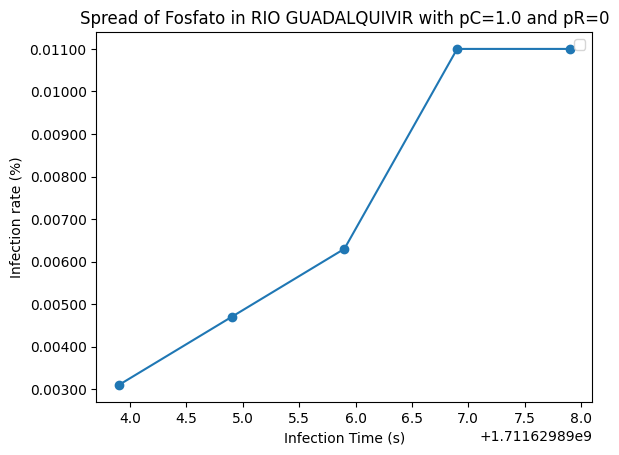

In [92]:
option1 = Menu1()